# PI² Research & Exploration - Advanced Stochastic Volatility Models

Volatility is not constant in real markets. In this notebook, we study the Heston and SABR models that capture stochastic behavior of volatility, and allow better option pricing and volatility surface fitting.

## Introduction

### An overview of volatility modelling in finance

Volatility is one of the most fundamental and studied concepts in quantitative finance. It measures the degree of variation or uncertainty in the price of a financial asset over time, reflecting how much returns deviate from their average value. In practical terms, high volatility implies larger and more unpredictable price swings, often associated with greater risk and potential reward for investors.

Classic financial models like Black–Scholes assume constant volatility, a simplification that makes analytic pricing possible but fails to capture real market behavior. Actual market volatility is time-varying, persistent, and exhibits asymmetric behavior: volatility tends to rise more after negative shocks than after positive ones.

Since the 1970s, multiple generations of volatility models have been developed to address these limitations. Statistical approaches, such as ARCH and GARCH models (Engle, R.), introduce conditional heteroskedasticity to describe volatility’s dynamics, while more advanced frameworks like stochastic volatility models treat volatility itself as a random process evolving according to its own SDE.

These developments have significantly improved the realism and predictive power of financial models. Stochastic volatility frameworks like the Heston and SABR models allow volatility to vary randomly over time and capture phenomena such as mean reversion, volatility smiles, and correlations between asset returns and variance.

## Mathematical Background

In the Black-Scholes model, the asset price is the only stochastic process, following a geometric brownian motion:

$$dS_t = \mu \cdot S_t \cdot dt + \sigma \cdot S_t \cdot dW^P_t$$

The log return follows a gaussian distribution:
$$\left\{
\begin{aligned}
S_T &= S_0 \cdot e^{\left(\mu - \frac{\sigma^2}{2}\right) \cdot T + \sigma \cdot W_T} \\
\ln\!\left(\frac{S_T}{S_0}\right) &\sim \mathcal{N}\!\left(\left(\mu - \frac{\sigma^2}{2}\right) \cdot T,\, \sigma^2 \cdot T\right)
\end{aligned}
\right.$$

In practice, historical returns have fatter tails.

For instance, let's take a look at the daily returns of the S&P500:

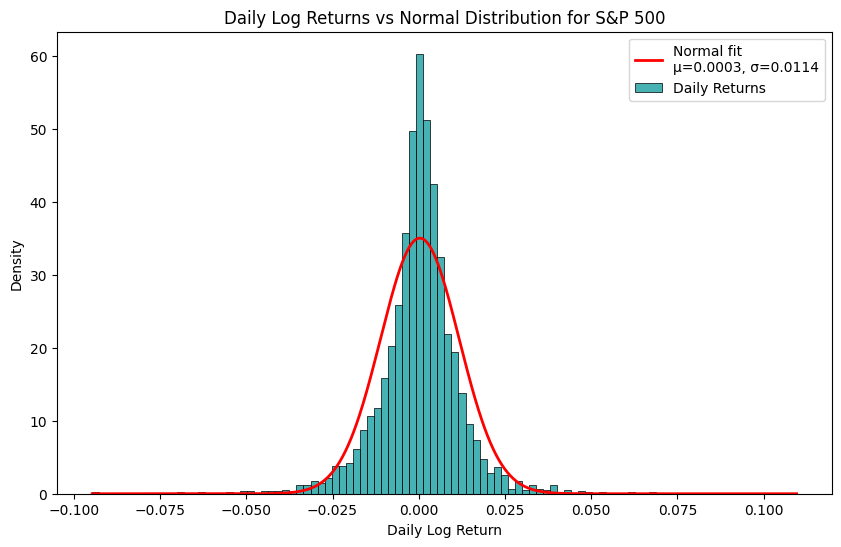

In [24]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

# daily data from 1986 to 2018 (from Kaggle)
sp500 = pd.read_csv("spx.csv")
sp500["Return"] = np.log(sp500["close"] / sp500["close"].shift(1))
mu, sigma = sp500["Return"].mean(), sp500["Return"].std()
sp500["date"] = pd.to_datetime(sp500["date"], format="%d-%b-%y")
sp500 = sp500[(sp500["date"] >= "2000-01-01") & (sp500["date"] <= "2018-12-31")]
# Plot histogram
plt.figure(figsize=(10,6))
sns.histplot(sp500["Return"], bins=100, kde=False, color="#09999B", stat='density', label='Daily Returns')

# Plot normal distribution
x = np.linspace(sp500["Return"].min(), sp500["Return"].max(), 1000)
plt.plot(x, norm.pdf(x, mu, sigma), 'r', lw=2, label=f'Normal fit\nμ={mu:.4f}, σ={sigma:.4f}')

plt.title(f'Daily Log Returns vs Normal Distribution for S&P 500')
plt.xlabel('Daily Log Return')
plt.ylabel('Density')
plt.legend()
plt.show()

As we can see, returns are not exactly normal.

Let's plot the daily log returns over time:

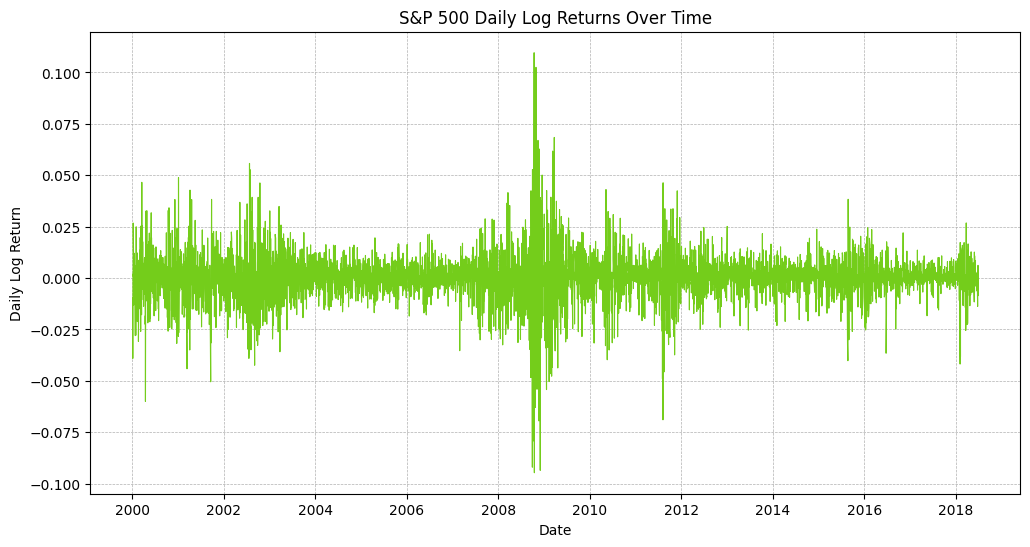

In [25]:
# Let's plot daily returns of the S&P
plt.figure(figsize=(12,6))
plt.plot(sp500["date"], sp500["Return"], color="#74CD1B", linewidth=0.8)
plt.title("S&P 500 Daily Log Returns Over Time")
plt.xlabel("Date")
plt.ylabel("Daily Log Return")
plt.grid(True, linestyle="--", linewidth=0.5)
plt.show()

We can look at the VIX index, that measures the market's expectation of volatility on the S&P500 over the next 30 days.

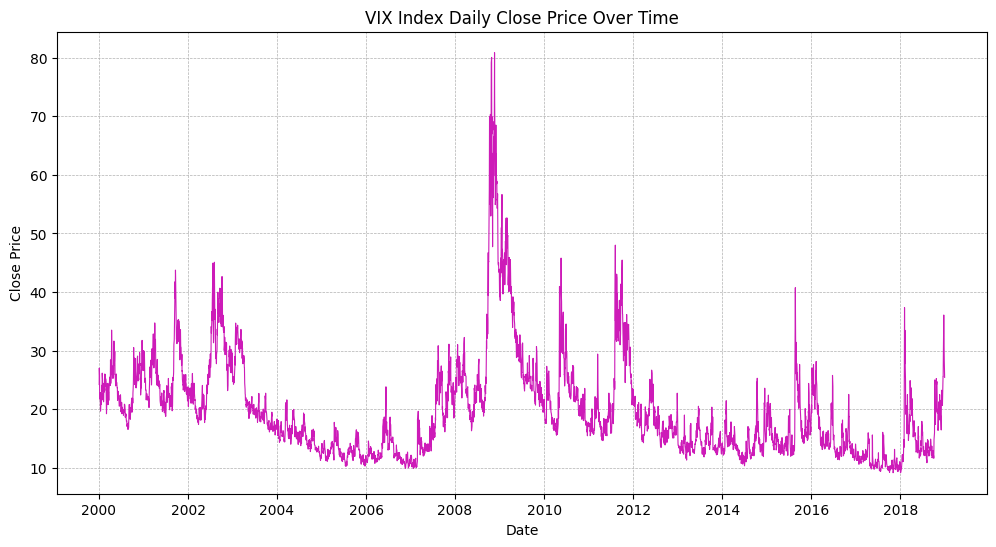

In [26]:
# Let's plot the VIX index
vix = pd.read_csv("vix_daily.csv")
vix["date"] = pd.to_datetime(vix["date"])
vix = vix[(vix["date"] >= "2000-01-01") & (vix["date"] <= "2018-12-31")]
vix.rename(columns={"close": "close_vix"}, inplace=True)
plt.figure(figsize=(12,6))
plt.plot(vix["date"], vix["close_vix"], color="#CD1BB8", linewidth=0.8)
plt.title("VIX Index Daily Close Price Over Time")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.grid(True, linestyle="--", linewidth=0.5)
plt.show()

We can see that actual volatility changes with time and we tend to observe higher volatilities in periods of market stress when stock returns are more negative. Here we plot the S&P returns vs the daily change of the VIX index to show this correlation:

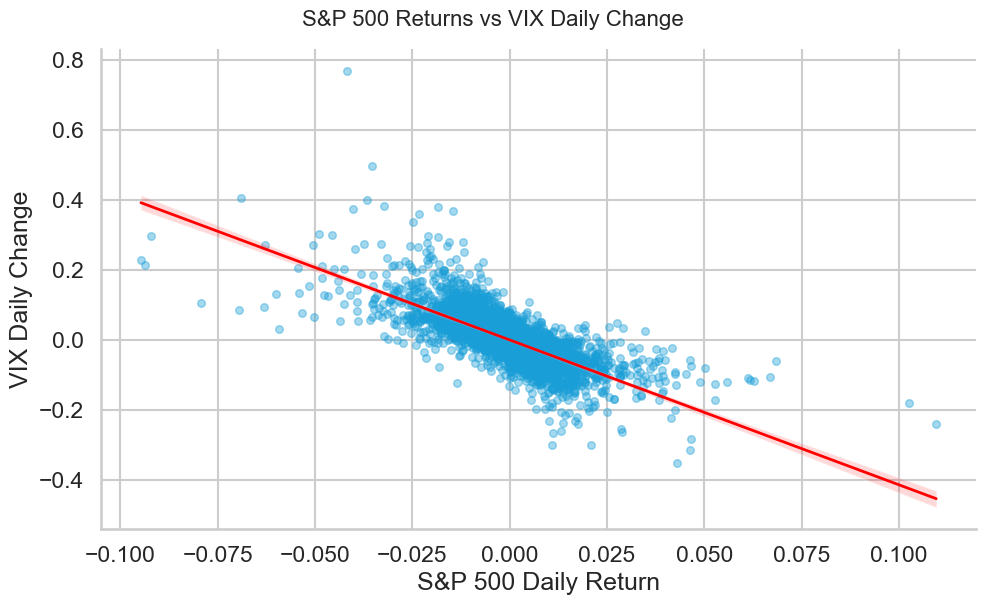

In [ ]:
sns.set_style("whitegrid")
sns.set_context("talk")
merged_index = pd.merge(sp500, vix, on="date", how="inner")
merged_index["Return_vix"] = np.log(merged_index["close_vix"] / merged_index["close_vix"].shift(1))
g = sns.lmplot(
    x="Return",
    y="Return_vix",
    data=merged_index,
    line_kws={"color": "red", "lw": 2},
    scatter_kws={"alpha": 0.4, "s": 30, "color": "#199ED7"},
    height=6,
    aspect=1.7  # wider
)

g.figure.suptitle("S&P 500 Returns vs VIX Daily Change", fontsize=16, y=1.02)
g.set_axis_labels("S&P 500 Daily Return", "VIX Daily Change")

plt.show()

Multiple stochastic volatility models try to represent more accurately the volatility behavior we described and can perform very well in different market scenarios.

## Heston Model

The Heston model, developed in 1993 by Heston, Steven L. assumes that volatility follows a mean-reverting square-root process (CIR process). It captures volatility clustering and smiles observed in real markets.

Volatility and asset price are assumed to be correlated.

The Heston model satisfies the following relations:
$$\begin{cases}
dS_t = \mu S_t\,dt + \sqrt{\nu_t}\,S_t\,dW_t^{(1)}, \\[6pt]
d\nu_t = \kappa(\theta - \nu_t)\,dt + \sigma\sqrt{\nu_t}\,dW_t^{(2)}, \\[6pt]
dW_t^{(1)}\,dW_t^{(2)} = \rho\,dt.
\end{cases}$$

With:

- $S_t$: underlying price
- $\nu_t$: instantaneous variance
- $\mu$: drift
- $\kappa$: mean reversion speed
- $\theta$: long-term variance
- $\sigma$: volatility of volatility (vol of vol)
- $\rho$: correlation between $W^{(1)}$ and $W^{(2)}$

## Bibliography: 
- Ribeiro, M. (2018). *Volatility Models in Option Pricing*, Master’s thesis, Instituto Superior Técnico.
- Quant Next. *Introduction to Stochastic Volatility Models*, [Website](https://quant-next.com/introduction-to-stochastic-volatility-models/).
- Yadav, P. (2024). *The SABR Volatility Model: Unlocking Realistic Market Behavior in Quantitative Finance*, [LinkedIn](https://www.linkedin.com/pulse/sabr-volatility-model-unlocking-realistic-market-behavior-yadav-r3kkc/).
- Chang, H. (2024). *Stochastic volatility models and their applications to financial markets*, Xi'an Jiaotong-Liverpool University, [Publication](https://www.ewadirect.com/proceedings/aemps/article/view/18738).